In [2]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [3]:
DATASET_PATH = "dataset"
X = []  # Almacenar las caracteristicas
y = []  # Almacenar las etiquetas

In [4]:
# Cargar TRAIN (7 imágenes por persona)
print("Cargando TRAIN...")
for label in os.listdir(os.path.join(DATASET_PATH, "train")):
    subcarpeta = os.path.join(DATASET_PATH, "train", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)  # Mejor contraste
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X = np.array(X)
y = np.array(y)

print(f"TRAIN: {len(X)} imagenes, {len(set(y))} personas")

Cargando TRAIN...
TRAIN: 112 imagenes, 16 personas


In [5]:
# Cargar VAL (2 imágenes por persona)
print("Cargando VAL...")
X_val = []
y_val = []

for label in os.listdir(os.path.join(DATASET_PATH, "val")):
    subcarpeta = os.path.join(DATASET_PATH, "val", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X_val.append(features)
            y_val.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"VAL: {len(X_val)} imagenes, {len(set(y_val))} personas")

Cargando VAL...
VAL: 32 imagenes, 16 personas


In [6]:
# Cargar TEST (1 imagen por persona)
print("Cargando TEST...")
X_test = []
y_test = []

for label in os.listdir(os.path.join(DATASET_PATH, "test")):
    subcarpeta = os.path.join(DATASET_PATH, "test", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X_test.append(features)
            y_test.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"TEST: {len(X_test)} imagenes, {len(set(y_test))} personas")

Cargando TEST...
TEST: 16 imagenes, 16 personas


In [7]:
# IMPORTANTE: Combinar TRAIN + VAL para maximizar datos de entrenamiento
# Asi usamos 9 imagenes por persona (7 de train + 2 de val) en lugar de solo 7
print("\n=== COMBINANDO TRAIN + VAL ===")
X_train = np.vstack([X, X_val])
y_train = np.concatenate([y, y_val])

print(f"Total para entrenamiento: {len(X_train)} imagenes ({len(X_train)//16} por persona)")
print(f"Total para test: {len(X_test)} imagenes (1 por persona)")


=== COMBINANDO TRAIN + VAL ===
Total para entrenamiento: 144 imagenes (9 por persona)
Total para test: 16 imagenes (1 por persona)


In [8]:
# Normalizar datos (mejora mucho el rendimiento)
print("\nNormalizando caracteristicas...")
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std
print("Normalizacion completada")


Normalizando caracteristicas...
Normalizacion completada


In [9]:
print("\n=== ENTRENANDO MODELO ===")

# Parametros optimizados para dataset con pocas imagenes
model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
model.fit(X_train_norm, y_train)

print("Modelo entrenado exitosamente")


=== ENTRENANDO MODELO ===
Modelo entrenado exitosamente


In [10]:
print("\n=== EVALUACION EN TEST ===")
y_pred_test = model.predict(X_test_norm)

accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"\nReport:")
print(classification_report(y_test, y_pred_test, zero_division=0))


=== EVALUACION EN TEST ===

Accuracy: 1.0000 (100.0%)

Report:
              precision    recall  f1-score   support

    AAlegria       1.00      1.00      1.00         1
       ALara       1.00      1.00      1.00         1
      ASaula       1.00      1.00      1.00         1
    BPepinos       1.00      1.00      1.00         1
  CCalapucha       1.00      1.00      1.00         1
     EChuico       1.00      1.00      1.00         1
   EZambrano       1.00      1.00      1.00         1
    FJimenez       1.00      1.00      1.00         1
   HQuintero       1.00      1.00      1.00         1
     JFranco       1.00      1.00      1.00         1
     JGuerra       1.00      1.00      1.00         1
    JJimenez       1.00      1.00      1.00         1
     JTorres       1.00      1.00      1.00         1
     MMolina       1.00      1.00      1.00         1
      PTapia       1.00      1.00      1.00         1
 RPuruncajas       1.00      1.00      1.00         1

    accuracy    

In [11]:
# Analisis detallado de predicciones
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
errores_lista = []

for real, pred in zip(y_test, y_pred_test):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    
    if real == pred:
        correctos += 1
    else:
        errores_lista.append((real, pred))

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(errores_lista)}/{len(y_test)}")

if errores_lista:
    print(f"\nPersonas mal clasificadas:")
    for real, pred in errores_lista:
        print(f"  - {real} -> clasificado como {pred}")


=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JGuerra         ✓ CORRECTO
JJimenez        JJimenez        ✓ CORRECTO
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     RPuruncajas     ✓ CORRECTO

Resumen:
  Correctos: 16/16 (100.0%)
  Errores: 0/16



IMAGENES DISPONIBLES PARA PROBAR:
1. AAlegria - img_10.jpeg
2. ALara - img_10.jpeg
3. ASaula - img_10.jpeg
4. BPepinos - img_10.jpeg
5. CCalapucha - img_10.jpeg
6. EChuico - img_10.jpeg
7. EZambrano - img_1.jpg
8. FJimenez - img_10.jpeg
9. HQuintero - img_10.jpg
10. JFranco - img_10.jpeg
11. JGuerra - img_10.jpg
12. JJimenez - img_10.jpeg
13. JTorres - img_10.jpeg
14. MMolina - img_10.jpeg
15. PTapia - img_10.jpeg
16. RPuruncajas - img_10.jpeg


PREDICCION #9
Persona real: HQuintero
Predicción: HQuintero
Confianza: 15.3017
Resultado: ✓ CORRECTO



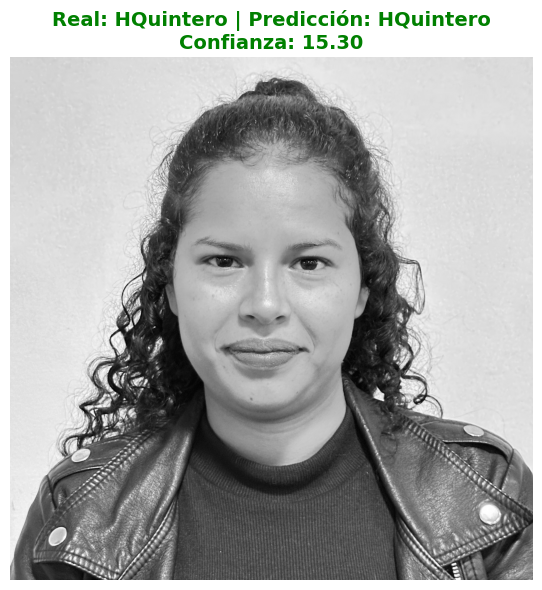

In [22]:
import matplotlib.pyplot as plt

def listar_imagenes_test():
    """
    Lista todas las imágenes de test con números
    """
    base_path = './dataset/test'
    personas = sorted(os.listdir(base_path))
    
    imagenes_disponibles = []
    contador = 1
    
    print("\n" + "="*60)
    print("IMAGENES DISPONIBLES PARA PROBAR:")
    print("="*60)
    
    for persona in personas:
        persona_path = os.path.join(base_path, persona)
        if not os.path.isdir(persona_path):
            continue
            
        imagenes = sorted(os.listdir(persona_path))
        
        for img in imagenes:
            ruta_completa = os.path.join(persona_path, img)
            imagenes_disponibles.append((contador, persona, ruta_completa))
            print(f"{contador}. {persona} - {img}")
            contador += 1
    
    print("="*60 + "\n")
    return imagenes_disponibles


def predecir_por_numero(numero, imagenes_disponibles):
    """
    Predice basándose en el número elegido
    """
    # Buscar la imagen
    imagen_info = None
    for num, persona, ruta in imagenes_disponibles:
        if num == numero:
            imagen_info = (persona, ruta)
            break
    
    if imagen_info is None:
        print(f"Error: No existe la imagen número {numero}")
        return
    
    persona_real, ruta = imagen_info
    
    print(f"\n{'='*60}")
    print(f"PREDICCION #{numero}")
    print(f"{'='*60}")
    print(f"Persona real: {persona_real}")
    
    # Leer y procesar - MISMO PROCESO QUE EN ENTRENAMIENTO
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Error: No se pudo leer la imagen {ruta}")
        return
    
    # IMPORTANTE: Mismo tamaño que entrenamiento (128x128)
    img_resized = cv2.resize(img, (128, 128))
    
    # IMPORTANTE: Ecualización de histograma (igual que en entrenamiento)
    img_equalized = cv2.equalizeHist(img_resized)
    
    # IMPORTANTE: Extraer HOG features (igual que en entrenamiento)
    features = hog(img_equalized, orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2))
    
    # Normalizar usando los mismos parámetros del entrenamiento
    features_normalized = (features - mean) / std
    features_normalized = features_normalized.reshape(1, -1)
    
    # Predecir
    prediccion = model.predict(features_normalized)[0]
    
    # Obtener probabilidades (confianza)
    decision_values = model.decision_function(features_normalized)[0]
    max_confidence = np.max(decision_values)
    
    print(f"Predicción: {prediccion}")
    print(f"Confianza: {max_confidence:.4f}")
    print(f"Resultado: {'✓ CORRECTO' if prediccion == persona_real else '✗ ERROR'}")
    print(f"{'='*60}\n")
    
    # Mostrar imagen
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')
    color = 'green' if prediccion == persona_real else 'red'
    plt.title(f"Real: {persona_real} | Predicción: {prediccion}\nConfianza: {max_confidence:.2f}", 
              color=color, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ==== USAR ASÍ ====

# 1. Listar todas las imágenes
imagenes = listar_imagenes_test()


predecir_por_numero(9, imagenes)

<h4>Random Forest</h4>

In [13]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*70)
print("MODELO 2: Random Forest - SUPERVISADO")
print("="*70)

# Entrenar
model_rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
model_rf.fit(X_train_norm, y_train)
print("✓ Modelo Random Forest entrenado")

# Evaluar
y_pred_rf = model_rf.predict(X_test_norm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n RESULTADOS Random Forest:")
print(f"Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.1f}%)")

# Análisis detallado
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
for real, pred in zip(y_test, y_pred_rf):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    if real == pred:
        correctos += 1

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(y_test)-correctos}/{len(y_test)}")

print(f"\nReporte completo:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


MODELO 2: Random Forest - SUPERVISADO
✓ Modelo Random Forest entrenado

 RESULTADOS Random Forest:
Accuracy: 0.8750 (87.5%)

=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         AAlegria        ✗ ERROR
JJimenez        JJimenez        ✓ CORRECTO
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     PTapia          ✗ ERROR

Resumen:
  Correctos: 14/16 (87.5%)
  Errores: 2/16

Reporte completo:


<h4>Gaussian Naive Bayes</h4>

In [14]:
from sklearn.naive_bayes import GaussianNB

print("\n" + "="*70)
print("MODELO 2: Gaussian Naive Bayes - SUPERVISADO")
print("="*70)

# Entrenar
model_gnb = GaussianNB()
model_gnb.fit(X_train_norm, y_train)
print("✓ Modelo Gaussian Naive Bayes entrenado")

# Evaluar
y_pred_gnb = model_gnb.predict(X_test_norm)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)

print(f"\nRESULTADOS Gaussian Naive Bayes:")
print(f"Accuracy: {accuracy_gnb:.4f} ({accuracy_gnb*100:.1f}%)")

# Análisis detallado
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
for real, pred in zip(y_test, y_pred_gnb):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    if real == pred:
        correctos += 1

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(y_test)-correctos}/{len(y_test)}")

print(f"\nReporte completo:")
print(classification_report(y_test, y_pred_gnb, zero_division=0))


MODELO 2: Gaussian Naive Bayes - SUPERVISADO
✓ Modelo Gaussian Naive Bayes entrenado

RESULTADOS Gaussian Naive Bayes:
Accuracy: 0.8750 (87.5%)

=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      PTapia          ✗ ERROR
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JGuerra         ✓ CORRECTO
JJimenez        JJimenez        ✓ CORRECTO
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     JGuerra         ✗ ERROR

Resumen:
  Correctos: 14/16 (87.5%)
  Errores: 2/16

<h4>Decision Tree </h4>

In [15]:
from sklearn.tree import DecisionTreeClassifier

print("\n" + "="*70)
print("MODELO 3: Decision Tree - SUPERVISADO")
print("="*70)

# Entrenar
model_dt = DecisionTreeClassifier(max_depth=15, min_samples_split=5, random_state=42)
model_dt.fit(X_train_norm, y_train)
print("✓ Modelo Decision Tree entrenado")

# Evaluar
y_pred_dt = model_dt.predict(X_test_norm)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"\n📊 RESULTADOS Decision Tree:")
print(f"Accuracy: {accuracy_dt:.4f} ({accuracy_dt*100:.1f}%)")

# Análisis detallado
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
for real, pred in zip(y_test, y_pred_dt):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    if real == pred:
        correctos += 1

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(y_test)-correctos}/{len(y_test)}")

print(f"\nReporte completo:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


MODELO 3: Decision Tree - SUPERVISADO
✓ Modelo Decision Tree entrenado

📊 RESULTADOS Decision Tree:
Accuracy: 0.3750 (37.5%)

=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           PTapia          ✗ ERROR
ASaula          ALara           ✗ ERROR
BPepinos        JFranco         ✗ ERROR
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       HQuintero       ✗ ERROR
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JJimenez        ✗ ERROR
JJimenez        JGuerra         ✗ ERROR
JTorres         AAlegria        ✗ ERROR
MMolina         JJimenez        ✗ ERROR
PTapia          AAlegria        ✗ ERROR
RPuruncajas     MMolina         ✗ ERROR

Resumen:
  Correctos: 6/16 (37.5%)
  Errores: 10/16

Reporte completo:
              precision

<h4>Regresión Logística </h4>

In [16]:
from sklearn.linear_model import LogisticRegression

print("\n" + "="*70)
print("MODELO 4: Logistic Regression - SUPERVISADO")
print("="*70)

# Entrenar
model_lr = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
model_lr.fit(X_train_norm, y_train)
print("✓ Modelo Logistic Regression entrenado")

# Evaluar
y_pred_lr = model_lr.predict(X_test_norm)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"\n📊 RESULTADOS Logistic Regression:")
print(f"Accuracy: {accuracy_lr:.4f} ({accuracy_lr*100:.1f}%)")

# Análisis detallado
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
for real, pred in zip(y_test, y_pred_lr):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    if real == pred:
        correctos += 1

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(y_test)-correctos}/{len(y_test)}")

print(f"\nReporte completo:")
print(classification_report(y_test, y_pred_lr, zero_division=0))


MODELO 4: Logistic Regression - SUPERVISADO
✓ Modelo Logistic Regression entrenado

📊 RESULTADOS Logistic Regression:
Accuracy: 0.9375 (93.8%)

=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JGuerra         ✓ CORRECTO
JJimenez        ALara           ✗ ERROR
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     RPuruncajas     ✓ CORRECTO

Resumen:
  Correctos: 15/16 (93.8%)
  Errores: 1/

<h4>K-Nearest Neighbors (KNN)</h4>

In [17]:
from sklearn.neighbors import KNeighborsClassifier

print("\n" + "="*70)
print("MODELO 5: K-Nearest Neighbors (KNN) - SUPERVISADO")
print("="*70)

model_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_knn.fit(X_train_norm, y_train)
print("✓ Modelo KNN entrenado")

y_pred_knn = model_knn.predict(X_test_norm)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"\n📊 RESULTADOS KNN:")
print(f"Accuracy: {accuracy_knn:.4f} ({accuracy_knn*100:.1f}%)")

print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
for real, pred in zip(y_test, y_pred_knn):
    simbolo = "✓" if real == pred else "✗"
    resultado = "CORRECTO" if real == pred else "ERROR"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    if real == pred:
        correctos += 1

print(f"\nResumen: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"\nReporte completo:")
print(classification_report(y_test, y_pred_knn, zero_division=0))


MODELO 5: K-Nearest Neighbors (KNN) - SUPERVISADO
✓ Modelo KNN entrenado

📊 RESULTADOS KNN:
Accuracy: 0.9375 (93.8%)

=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JGuerra         ✓ CORRECTO
JJimenez        ALara           ✗ ERROR
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     RPuruncajas     ✓ CORRECTO

Resumen: 15/16 (93.8%)

Reporte completo:
              precision    recall


COMPARACIÓN FINAL DE LOS 6 MODELOS SUPERVISADOS

📊 Tabla de Resultados:
       Modelo  Accuracy
          SVM    1.0000
Logistic Reg.    0.9375
          KNN    0.9375
  Gaussian NB    0.8750
Random Forest    0.8750
Decision Tree    0.3750


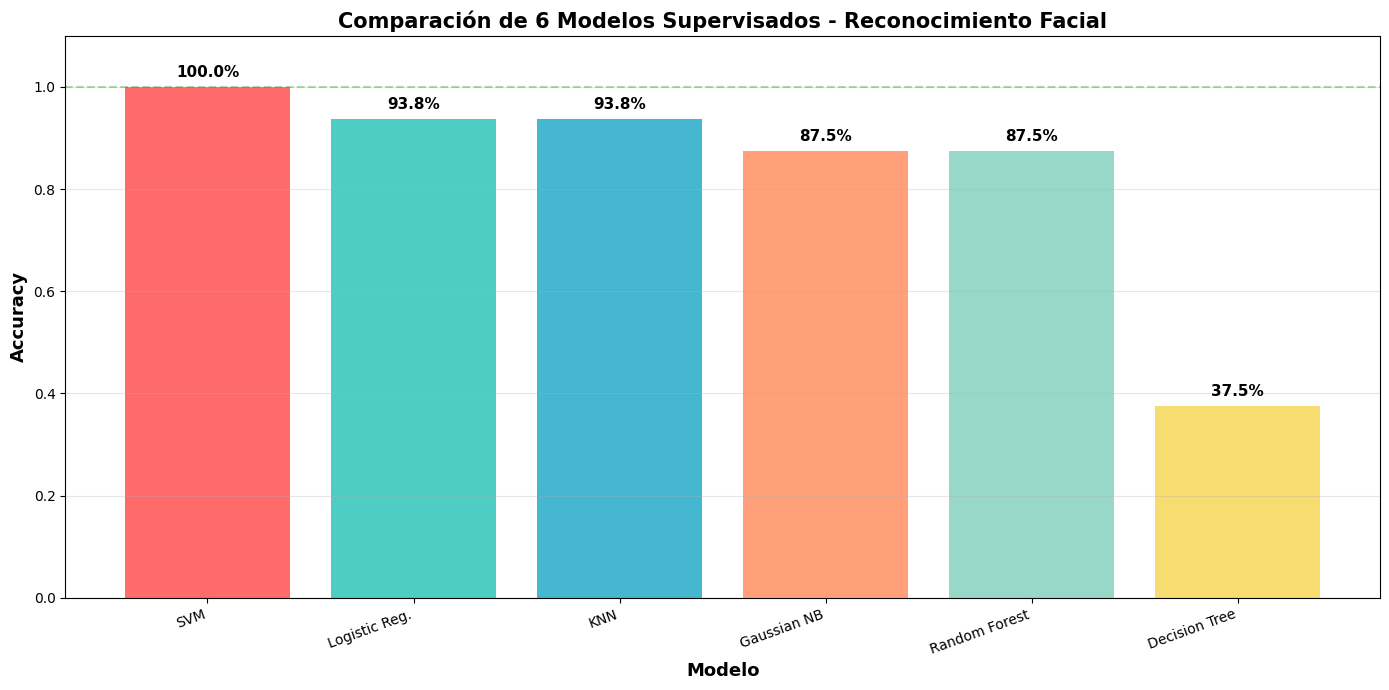


🏆 MEJOR MODELO: SVM
   Accuracy: 100.0%


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("COMPARACIÓN FINAL DE LOS 6 MODELOS SUPERVISADOS")
print("="*70)

resultados = {
    'Modelo': ['SVM', 'Gaussian NB', 'Decision Tree', 'Logistic Reg.', 'Random Forest', 'KNN'],
    'Accuracy': [
        accuracy_score(y_test, model.predict(X_test_norm)),  # SVM
        accuracy_gnb,
        accuracy_dt,
        accuracy_lr,
        accuracy_rf,
        accuracy_knn
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('Accuracy', ascending=False)

print("\n📊 Tabla de Resultados:")
print(df_resultados.to_string(index=False))

# Gráfico
plt.figure(figsize=(14, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

plt.bar(df_resultados['Modelo'], df_resultados['Accuracy'], color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.xlabel('Modelo', fontsize=13, fontweight='bold')
plt.title('Comparación de 6 Modelos Supervisados - Reconocimiento Facial', fontsize=15, fontweight='bold')
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.3)

for i, (modelo, acc) in enumerate(zip(df_resultados['Modelo'], df_resultados['Accuracy'])):
    plt.text(i, acc + 0.02, f'{acc*100:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🏆 MEJOR MODELO: {df_resultados.iloc[0]['Modelo']}")
print(f"   Accuracy: {df_resultados.iloc[0]['Accuracy']*100:.1f}%")